In [ ]:
!git clone --recurse-submodules https://github.com/Ryan-Qiyu-Jiang/stereo_segmentation.git
%cd /content/stereo_segmentation/

In [ ]:
%cd /content/stereo_segmentation/rloss/pytorch/wrapper/bilateralfilter
!apt-get install swig -y
!swig -python -c++ bilateralfilter.i
!python setup.py install

In [ ]:
%cd /content/stereo_segmentation/rloss/data/VOC2012/

/content/stereo_segmentation/rloss/data/VOC2012


In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# rm -r JPEGImages

In [ ]:
# !cp '/gdrive/My Drive/VOCtrainval_11-May-2012.tar' ./
# !tar -xvf VOCtrainval_11-May-2012.tar
# !ln -s VOCdevkit/VOC2012/JPEGImages JPEGImages

In [ ]:
!./fetchVOC2012.sh

In [ ]:
%cd /content/stereo_segmentation/rloss/data/pascal_scribble/
! ./fetchPascalScribble.sh

In [ ]:
# %cd /content/stereo_segmentation
# !git pull --recurse-submodules

In [ ]:
!pip install -qqq tensorboardX
!pip install -qqq wandb
!pip install -qqq pytorch-lightning

In [ ]:
%cd /content/stereo_segmentation/rloss/pytorch/pytorch-deeplab_v3_plus
from trainer_pl import SegModel, get_args, Mutiscale_Seg_Model, Variable_Bandwidth_Model
from dataloaders import make_data_loader

/content/stereo_segmentation/rloss/pytorch/pytorch-deeplab_v3_plus


In [ ]:
import argparse
import os
import numpy as np
from tqdm import tqdm

from mypath import Path
from dataloaders import make_data_loader
from dataloaders.custom_transforms import denormalizeimage
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator
from dataloaders.utils import decode_seg_map_sequence

from DenseCRFLossLog import DenseCRFLoss as DenseCRFLossLog
from DenseCRFLoss import DenseCRFLoss

import matplotlib
import matplotlib.cm
from torchvision.utils import make_grid
from torch.nn import functional as F
import pytorch_lightning as pl
from torch import nn
import torch
from argparse import Namespace
from dataloaders.utils import decode_seg_map_sequence

def colorize(value, vmin=None, vmax=None, cmap=None):
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    value = value.squeeze()

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=False) # (nxmx4)
    return value

In [ ]:
from dataloaders.utils import decode_seg_map_sequence

segmentation_classes = [
    'background','aeroplane','bicycle','bird','boat','bottle',
    'bus','car','cat','chair','cow','diningtable','dog','horse',
    'motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'
]

def labels():
  l = {}
  for i, label in enumerate(segmentation_classes):
    l[i] = label
  return l

def wb_mask(bg_img, pred_mask, true_mask):
  return wandb.Image(bg_img, masks={
    "prediction" : {"mask_data" : pred_mask, "class_labels" : labels()},
    "ground truth" : {"mask_data" : true_mask, "class_labels" : labels()}})

class SegModel(pl.LightningModule):
    def __init__(self, hparams, nclass=21, num_img_tr=800, load_model=True):
        super().__init__()
        if not hparams:
            print('Loading default hyperparams!')
            hparams = Namespace(**get_args())
        if type(hparams) is dict:
            print('Converting hparam dict to namespace!')
            hparams = Namespace(**hparams)
        self.hparams = hparams
        self.update_loggers()
        self.lr = hparams.lr
        self.nclass = nclass
        self.hparams.nclass = nclass
        self.hparams.num_img_tr = num_img_tr
        self.num_img_tr = num_img_tr
        self.best_pred = 0.0
        self.logit_scale = None
        self.entropy_weight = 2e-9
        self.log_counter = 0
        self.val_img_logs = []
        self.evaluator = Evaluator(self.nclass)
        kwargs = {'num_workers': hparams.workers, 'pin_memory': True}
        # self.train_loader, self.val_loader, self.test_loader, self.nclass = make_data_loader(self.hparams, **kwargs)
        if load_model:
            self.model = DeepLab(num_classes=self.nclass,
                            backbone=self.hparams.backbone,
                            output_stride=self.hparams.out_stride,
                            sync_bn=self.hparams.sync_bn,
                            freeze_bn=self.hparams.freeze_bn)

        if self.hparams.use_balanced_weights:
            classes_weights_path = os.path.join(Path.db_root_dir(self.hparams.dataset), self.hparams.dataset+'_classes_weights.npy')
            if os.path.isfile(classes_weights_path):
                weight = np.load(classes_weights_path)
            else:
                weight = calculate_weigths_labels(self.hparams.dataset, self.train_loader, self.nclass)
            weight = torch.from_numpy(weight.astype(np.float32))
        else:
            weight = None
        self.criterion = SegmentationLosses(weight=weight, cuda=self.hparams.cuda).build_loss(mode=self.hparams.loss_type)
        self.densecrflosslayer = DenseCRFLoss(weight=1, sigma_rgb=self.hparams.sigma_rgb, sigma_xy=self.hparams.sigma_xy, scale_factor=self.hparams.rloss_scale)
        
        self.evaluator = Evaluator(self.nclass)

        # Clear start epoch if fine-tuning
        if self.hparams.ft:
            self.hparams.start_epoch = 0

        self.save_hyperparameters()

    def log(self, name, value):
      self.logger.experiment.log({name : value})

    def update_loggers(self):
        self.saver = Saver(self.hparams)
        self.saver.save_experiment_config()
        self.summary = TensorboardSummary(self.saver.experiment_dir)
        self.writer = self.summary.create_summary()

    def forward(self, x):
        return self.model(x) 

    def configure_optimizers(self):
        train_params = [{'params': self.model.get_1x_lr_params(), 'lr': self.lr},
                        {'params': self.model.get_10x_lr_params(), 'lr': self.lr * 10}]
        self.optimizer = torch.optim.SGD(train_params, momentum=self.hparams.momentum, 
                                                weight_decay=self.hparams.weight_decay, 
                                                nesterov=self.hparams.nesterov)
        self.scheduler = LR_Scheduler(self.hparams.lr_scheduler, self.hparams.lr,
                                            self.hparams.epochs, self.num_img_tr)
        return self.optimizer #[self.optimizer], [self.scheduler]

    def get_loss_val(self, batch, batch_idx):
        image, target = batch['image'], batch['label']
        # global_step = batch_idx + self.num_img_tr * self.val_counter
        croppings = (target!=254).float()
        target[target==254]=255

        output = self.model(image)
        celoss = self.criterion(output, target)

        flat_output = decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                    dataset=self.hparams.dataset)
        # self.logger.experiment.log({'val/Image-output-target':[wandb.Image(image[0]), wandb.Image(flat_output[0]), wandb.Image(target[0])] }, commit=False)
        # img_overlay = 0.3*image[:3].clone().cpu().data + 0.7*flat_output
        # self.logger.experiment.log({'val/Overlay':wandb.Image(img_overlay)}, commit=False)
        mask = torch.max(output[:1],1)[1].detach()
        self.val_img_logs += [wb_mask(image[0].cpu().numpy().transpose([1,2,0]), mask[0].cpu().numpy(), target[0].cpu().numpy())]

        pred = output.data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        target = target.cpu().numpy()
        self.evaluator.add_batch(target, pred)
        result = {
          'ce_loss': celoss
        }
        return result

    def validation_summary(self, outputs):
      test_loss = 0.0
      masks = self.val_img_logs
      self.val_img_logs = []
      print(len(masks))
      for output in outputs:
        test_loss += output['ce_loss']

      # Fast test during the training
      Acc = self.evaluator.Pixel_Accuracy()
      Acc_class = self.evaluator.Pixel_Accuracy_Class()
      mIoU = self.evaluator.Mean_Intersection_over_Union()
      FWIoU = self.evaluator.Frequency_Weighted_Intersection_over_Union()
      if len(masks)>10:
        self.logger.experiment.log({'val/Examples':masks[:50]}, commit=False)
      self.logger.experiment.log({'val/mIoU': mIoU}, commit=False)
      self.logger.experiment.log({'val/Acc': Acc}, commit=False)
      self.logger.experiment.log({'val/Acc_class': Acc_class}, commit=False)
      self.logger.experiment.log({'val/fwIoU': FWIoU}, commit=False)
      self.logger.experiment.log({'val/loss_epoch': test_loss.item()})
      print('Validation:')
      print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
      print('Loss: %.3f' % test_loss)
      self.evaluator.reset()

    def validation_epoch_end(self, validation_step_outputs):
      self.validation_summary(validation_step_outputs)

    def get_loss(self, batch, batch_idx):
        i = batch_idx
        epoch = self.current_epoch
        sample = batch
        num_img_tr = self.num_img_tr
        global_step = i + num_img_tr * epoch
        image, target = sample['image'], sample['label']
        croppings = (target!=254).float()
        target[target==254]=255
        num_logs = 50
        do_log = i%50==0 #(i % (num_img_tr // num_logs) == 0 or (self.detailed_early and (i + num_img_tr * epoch) < 100 and (i%5)==0))
        self.scheduler(self.optimizer, i, epoch, self.best_pred)
        self.optimizer.zero_grad()
        output = self.model(image)
        
        celoss = self.criterion(output, target)
        if self.hparams.densecrfloss ==0:
            probs = nn.Softmax(dim=1)(output)
            entropy = torch.sum(-probs*torch.log(probs+1e-9))
            loss = celoss + self.entropy_weight*entropy
            self.logger.experiment.log({'train/entropy': entropy.item()}, commit=False)
        else:
            self.densecrflosslayer = self.densecrflosslayer.to('cpu')
            max_output = (max(torch.abs(torch.max(output)), 
                                torch.abs(torch.min(output))))
            mean_output = torch.mean(torch.abs(output)).item()
            if self.logit_scale is None:
                probs = nn.Softmax(dim=1)(output) # /max_output*4
            else:
                probs = nn.Softmax(dim=1)(output/max_output*self.logit_scale)
            denormalized_image = denormalizeimage(sample['image'], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            densecrfloss = self.hparams.densecrfloss*self.densecrflosslayer(denormalized_image,probs,croppings)
            if self.hparams.cuda:
                densecrfloss = densecrfloss.cuda()
            loss = celoss + densecrfloss

            """All the code under here is for logging.
            """
            logits_copy = output.detach().clone().requires_grad_(True)
            max_output_copy = (max(torch.abs(torch.max(logits_copy)), 
                                torch.abs(torch.min(logits_copy))))
            probs_copy = nn.Softmax(dim=1)(logits_copy) # /max_output_copy*4
            denormalized_image_copy = denormalized_image.detach().clone()
            croppings_copy = croppings.detach().clone()
            densecrfloss_copy = self.hparams.densecrfloss*self.densecrflosslayer(denormalized_image_copy, probs_copy, croppings_copy)

            @torch.no_grad()
            def add_grad_map(grad, plot_name):
                if do_log:
                    global_step = i + num_img_tr * epoch
                    batch_grads = torch.max(torch.abs(grad), dim=1)[0].detach().cpu().numpy()
                    color_imgs = []
                    for grad_img in batch_grads:
                        grad_img[0,0]=0
                        img = colorize(grad_img)[:,:,:3]
                        color_imgs.append(img)
                    color_imgs = torch.from_numpy(np.array(color_imgs).transpose([0, 3, 1, 2]))
                    # grid_image = make_grid(color_imgs[:3], 3, normalize=False, range=(0, 255))
                    self.logger.experiment.log({plot_name:wandb.Image(color_imgs[:3])}, commit=False) 
                    # self.writer.add_image(plot_name, grid_image, global_step)

            def add_probs_map(grad, class_idx):
              if do_log:
                global_step = i + num_img_tr * epoch
                batch_grads = grad[:,class_idx,::].detach().cpu().numpy()
                color_imgs = []
                for grad_img in batch_grads:
                    grad_img[0,0]=0
                    img = colorize(grad_img)[:,:,:3]
                    color_imgs.append(img)
                color_imgs = torch.from_numpy(np.array(color_imgs).transpose([0, 3, 1, 2]))
                # grid_image = make_grid(color_imgs[:3], 3, normalize=False, range=(0, 255))
                self.logger.experiment.log({'Grad Probs {}'.format(class_idx) : wandb.Image(color_imgs[:3])}, commit=False)
                # self.writer.add_image('Grad Probs {}'.format(class_idx), grid_image, global_step)

            output.register_hook(lambda grad: add_grad_map(grad, 'Grad Logits')) 
            probs.register_hook(lambda grad: add_grad_map(grad, 'Grad Probs')) 
            probs.register_hook(lambda grad: add_probs_map(grad, 0)) 
            
            logits_copy.register_hook(lambda grad: add_grad_map(grad, 'Grad Logits Rloss')) 
            densecrfloss_copy.backward()
            self.logger.experiment.log({'train/rloss': densecrfloss.item()}, commit=False)

        if do_log:
            global_step = i + num_img_tr * epoch
            probs = nn.Softmax(dim=1)(output)
            img_entropy = torch.sum(-probs*torch.log(probs+1e-9), dim=1).detach().cpu().numpy()
            color_imgs = []
            for e in img_entropy:
                e[0,0] = 0
                img = colorize(e)[:,:,:3]
                color_imgs.append(img)
            color_imgs = torch.from_numpy(np.array(color_imgs).transpose([0, 3, 1, 2]))
            flat_output = decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                       dataset=self.hparams.dataset)
            img_overlay = 0.3*image[:3].clone().cpu().data + 0.7*flat_output

            self.logger.experiment.log({'Entropy':wandb.Image(color_imgs[:3])}, commit=False)
            flat_output = decode_seg_map_sequence(torch.max(output[:3], 1)[1].detach().cpu().numpy(),
                                                       dataset=self.hparams.dataset)
            self.logger.experiment.log({'Image-output-target':[wandb.Image(image[0]), wandb.Image(flat_output[0]), wandb.Image(target[0])]}, commit=False)
            img_overlay = 0.3*image[:3].clone().cpu().data + 0.7*flat_output
            # overlay_grid = make_grid(img_overlay, 3, normalize=True)
            self.logger.experiment.log({'Overlay':wandb.Image(img_overlay)}, commit=False)
            bg_probs = probs[:,0,::].detach().cpu().numpy()
            color_imgs = []
            for prob_img in bg_probs:
                prob_img[0,0]=0
                img = colorize(prob_img)[:,:,:3]
                color_imgs.append(img)
            color_imgs = torch.from_numpy(np.array(color_imgs).transpose([0, 3, 1, 2]))
            grid_image = make_grid(color_imgs[:3], 3, normalize=False, range=(0, 255))
            self.logger.experiment.log({'Background Softmax':wandb.Image(color_imgs[:3])}, commit=False)

        self.logger.experiment.log({'train/ce': celoss.item()}, commit=False)
        self.logger.experiment.log({'train/total_loss': loss.item()})
        return loss
        
    def training_step(self, batch, batch_idx):
        return self.get_loss(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx):
        return self.get_loss_val(batch, batch_idx)
    
    def test_step(self, batch, batch_idx):
        return self.get_loss_val(batch, batch_idx)

    def validation(self, val_loader, epoch=0):
        self.model.eval()
        self.evaluator.reset()
        tbar = tqdm(val_loader, desc='\r')
        test_loss = 0.0
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            target[target==254]=255
            if image.is_cuda:
                image, target = image.cuda(), target.cuda()
            with torch.no_grad():
                output = self.model(image)
            loss = self.criterion(output, target)
            test_loss += loss.item()
            tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
            pred = output.data.cpu().numpy()
            target = target.cpu().numpy()
            pred = np.argmax(pred, axis=1)
            # Add batch sample into evaluator
            self.evaluator.add_batch(target, pred)

        # Fast test during the training
        Acc = self.evaluator.Pixel_Accuracy()
        Acc_class = self.evaluator.Pixel_Accuracy_Class()
        mIoU = self.evaluator.Mean_Intersection_over_Union()
        FWIoU = self.evaluator.Frequency_Weighted_Intersection_over_Union()
        self.log('val/total_loss_epoch', test_loss)
        self.log('val/mIoU', mIoU)
        self.log('val/Acc', Acc)
        self.log('val/Acc_class', Acc_class)
        self.log('val/fwIoU', FWIoU)
        print('Validation:')
        print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
        print('Loss: %.3f' % test_loss)

In [ ]:
from argparse import Namespace
args_dict = get_args()
args_dict['cuda'] = True
args_dict['checkname'] = 'ignore'
args_dict['epochs'] = 1
args_dict['shuffle'] = True
args_dict['batch_size'] = 10
args_dict['lr'] = 1e-3
args_dict['full_gt'] = True
args_dict['limit_dataset'] = False
# args_dict['rloss_scale'] = 1
args = Namespace(**args_dict)

In [ ]:
kwargs = {'num_workers': 6, 'pin_memory': True}
train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)

Number of images in train: 10582
Number of images in val: 1449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


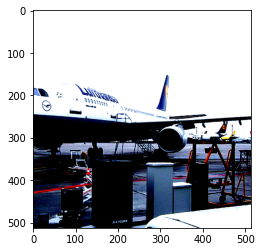

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
class SingleDataset(torch.utils.data.Dataset):
    def __init__(self, batch, length):
        self.batch = batch
        self.length = length

    def __getitem__(self, index):
        return self.batch

    def __len__(self):
        return self.length

class RepeatDataset(torch.utils.data.Dataset):
    def __init__(self, batch, length):
        self.batch = batch
        self.length = length

    def __getitem__(self, index):
        i = index % len(batch['image'])
        b = {
            'image': self.batch['image'][i],
            'label': self.batch['label'][i]
        }
        return b

    def __len__(self):
        return self.length

batch = iter(val_loader).next()
batch_sample = {k:v for k,v in batch.items()}
single_dataset = RepeatDataset(batch_sample, 100*10)
single_loader = DataLoader(single_dataset, batch_size=10, shuffle=True, num_workers=4)
plt.imshow(batch['image'][0].numpy().transpose(1,2,0));

In [ ]:
from PIL import Image
import cv2
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime, os
from pytorch_lightning import loggers as pl_loggers

import argparse
import os
import numpy as np
from tqdm import tqdm

from mypath import Path
from dataloaders import make_data_loader
from dataloaders.custom_transforms import denormalizeimage
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator
from dataloaders.utils import decode_seg_map_sequence

from DenseCRFLossLog import DenseCRFLoss as DenseCRFLossLog
from DenseCRFLoss import DenseCRFLoss

import matplotlib
import matplotlib.cm
from torchvision.utils import make_grid
from torch.nn import functional as F
import pytorch_lightning as pl
from torch import nn
import torch
from argparse import Namespace
from dataloaders.utils import decode_seg_map_sequence

def colorize(value, vmin=None, vmax=None, cmap=None):
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    value = value.squeeze()

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=False) # (nxmx4)
    return value

In [ ]:
class SimpleDecoder(SegModel):
    def __init__(self, hparams, nclass=21, num_img_tr=800, load_model=True):
        super().__init__(hparams, nclass, num_img_tr, load_model=True)
        self.hparams.A = torch.randn(256, 344).cuda()/256**0.5
        self.decoder_loss = True
        BatchNorm = nn.BatchNorm2d
        
    def get_simple_decoder_loss(self, batch, batch_idx, stage='train'):
        i = batch_idx
        epoch = self.current_epoch
        sample = batch
        num_img_tr = self.num_img_tr
        global_step = i + num_img_tr * epoch
        image, target = sample['image'], sample['label']
        croppings = (target!=254).float()
        target[target==254]=255
        num_logs = 50
        do_log = (i % (num_img_tr // num_logs) == 0 or ((i + num_img_tr * epoch) < 100 and i%5==0))
        self.scheduler(self.optimizer, i, epoch, self.best_pred)
        self.optimizer.zero_grad()
        encoder_x, encoder_low_level_feat = self.model.backbone(image)
        x = self.model.aspp(encoder_x)
        low_level_feat = self.model.decoder.conv1(encoder_low_level_feat)
        low_level_feat = self.model.decoder.bn1(low_level_feat)
        low_level_feat = self.model.decoder.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        y_hat = self.model.decoder.last_conv[:-1](x)

        encoder_x = F.interpolate(encoder_x, size=encoder_low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        y = torch.cat((encoder_x, encoder_low_level_feat), dim=1)

        s = y_hat.shape
        y_hat = y_hat.view(s[0], s[1], s[2]*s[3])
        s = y.shape
        y = y.view(s[0], s[1], s[2]*s[3])

        y_projects = [torch.matmul(self.hparams.A, features).unsqueeze(0) for features in y]
        y_project = torch.cat(y_projects, dim=0)

        l2_criterion = nn.MSELoss()
        l2_loss = l2_criterion(y_hat, y_project)
        
        self.log('{}/mse'.format(stage), l2_loss.item())
        return l2_loss

    def training_step(self, batch, batch_idx):
        if self.decoder_loss:
          return self.get_simple_decoder_loss(batch, batch_idx)
        return self.get_loss(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        if self.decoder_loss:
          return self.get_simple_decoder_loss(batch, batch_idx, stage='val')
        return self.get_loss_val(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        if not self.decoder_loss:
          self.validation_summary(outputs)

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# train overfit batch
for i in range(10):
  # train decoder on random projection
  args.batch_size = 10
  args.limit_dataset = False
  train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
  model = SimpleDecoder(args, nclass=nclass, num_img_tr=len(train_loader))
  model.decoder_loss = True
  model.num_img_tr = len(train_loader)
  model.hparams.densecrfloss = 0
  model.entropy_weight = 0
  model.hparams.lr = 0.01
  model.hparams.epochs = 5
  model.configure_optimizers()
  for param in model.model.backbone.parameters():
    param.requires_grad = False
  
  wandb_logger = WandbLogger(project='Pretrain-Decoder', name='5-epochs_pretrain-decoder_10_1e-2')
  trainer = pl.Trainer(gpus=1, max_epochs=5, logger=wandb_logger, log_every_n_steps=20, num_sanity_val_steps=10, progress_bar_refresh_rate=0)
  results = trainer.fit(model, train_loader, val_loader)
  trainer.save_checkpoint('/content/pretrained-decoder_10_1e-2.pth')
  wandb.finish()

  # retrain full decoder on overfit batch
  batch = iter(train_loader).next()
  batch_sample = {k:v for k,v in batch.items()}
  single_dataset = RepeatDataset(batch_sample, 100*10)
  single_loader = DataLoader(single_dataset, batch_size=10, shuffle=True, num_workers=4)
  model = SimpleDecoder.load_from_checkpoint('/content/pretrained-decoder_10_1e-2.pth')
  model.decoder_loss = False
  model.num_img_tr = len(single_loader)
  model.hparams.densecrfloss = 0
  model.entropy_weight = 0
  model.hparams.lr = 0.007
  model.hparams.epochs = 5
  model.configure_optimizers()
  for param in model.model.parameters():
    param.requires_grad = True

  wandb_logger = WandbLogger(project='Pretrain-Decoder', name='overfit_retrain-pretrained-5-decoder_10_7e-3')
  trainer = pl.Trainer(gpus=1, max_epochs=5, logger=wandb_logger, log_every_n_steps=20, num_sanity_val_steps=10, progress_bar_refresh_rate=0)
  results = trainer.fit(model, single_loader, single_loader)

  wandb.finish()


In [ ]:
# Train on small dataset
for i in range(5):
  # train decoder on random projection
  args.batch_size = 10
  args.limit_dataset = False
  train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
  model = SimpleDecoder(args, nclass=nclass, num_img_tr=len(train_loader))
  model.decoder_loss = True
  model.num_img_tr = len(train_loader)
  model.hparams.densecrfloss = 0
  model.entropy_weight = 0
  model.hparams.lr = 0.01
  model.hparams.epochs = 15
  model.configure_optimizers()
  for param in model.model.backbone.parameters():
    param.requires_grad = False
  
  wandb_logger = WandbLogger(project='Pretrain-Decoder', name='15-epochs_pretrain-decoder_10_1e-2')
  trainer = pl.Trainer(gpus=1, max_epochs=15, logger=wandb_logger, log_every_n_steps=20, num_sanity_val_steps=10, progress_bar_refresh_rate=0)
  results = trainer.fit(model, train_loader, val_loader)
  trainer.save_checkpoint('/content/pretrained-decoder_10_1e-2.pth')
  wandb.save('/content/pretrained-decoder_10_1e-2.pth.pth')
  wandb.finish()

  # train the last 2 layers
  args.batch_size = 10
  args.limit_dataset = 0.1
  train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
  model = SimpleDecoder.load_from_checkpoint('/content/pretrained-decoder_10_1e-2.pth')
  model.decoder_loss = False
  model.num_img_tr = len(train_loader)
  model.hparams.densecrfloss = 0
  model.entropy_weight = 0
  model.hparams.lr = 0.007
  model.hparams.epochs = 5
  model.configure_optimizers()
  for name, param in model.named_parameters():
    if not 'last_conv.8' in name and not 'last_conv.5' in name and not 'last_conv.4' in name:
      param.requires_grad = False
    else:
      param.requires_grad = True
  
  wandb_logger = WandbLogger(project='Pretrain-Decoder', name='5-epochs_pretrain-2-layer_10_7e-3')
  trainer = pl.Trainer(gpus=1, max_epochs=5, logger=wandb_logger, log_every_n_steps=20, num_sanity_val_steps=10, progress_bar_refresh_rate=0)
  results = trainer.fit(model, train_loader, val_loader)
  trainer.save_checkpoint('/content/full-pretrained-decoder_10_7e-3.pth')
  wandb.finish()

  # retrain full decoder on small dataset
  args.limit_dataset = 0.1
  train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
  model = SimpleDecoder.load_from_checkpoint('/content/full-pretrained-decoder_10_7e-3.pth')
  model.decoder_loss = False
  model.num_img_tr = len(train_loader)
  model.hparams.densecrfloss = 0
  model.entropy_weight = 0
  model.hparams.lr = 0.007
  model.hparams.epochs = 15
  model.configure_optimizers()
  for param in model.model.parameters():
    param.requires_grad = True

  wandb_logger = WandbLogger(project='Pretrain-Decoder', name='small_retrain-fully-pretrained-15-decoder_10_7e-3')
  trainer = pl.Trainer(gpus=1, max_epochs=15, logger=wandb_logger, log_every_n_steps=20, num_sanity_val_steps=10, progress_bar_refresh_rate=0)
  results = trainer.fit(model, train_loader, val_loader)

  wandb.finish()
